In [1]:
import numpy as np
import pptk
import networkx as nx
import imageio
import glob
import re
from scipy.spatial import distance
from random import sample
import matplotlib.pyplot as plt
from scipy.spatial import distance

In [2]:
def displayPoints(data, pointSize):
    v = pptk.viewer(data)
    v.set(point_size=pointSize)

In [3]:
# given the file path of PNGs, return the MST of the point cloud generated from the PNG files
def getMSTFromPNG(filePath):
    # Read points data from PNGs 
    data = ReadPointFromPNG(filePath)
    # sample 5000 points from the whole set, otherwise it would take too long
    sample_data = sample(data, 5000)
    #display the points 
    displayPoints(sample_data, 1.3)
    #Create a networkX graph instance that represent MST
    MST = CreateMSTGraph(sample_data)
    return MST
    

In [4]:
def readPointFromTXT(filepath):
    data = np.genfromtxt(fname=filepath, skip_header=0)
    return data

In [5]:
def ReadPointFromPNG(filepath):
    path_list = [im_path for im_path in glob.glob(filepath)]
    path_list_parsed = [re.split('\/|\.', path) for path in path_list]
    path_list_parsed_valid = [x for x in path_list_parsed if x[-1] == 'png']
    path_list_parsed_valid = sorted(path_list_parsed_valid, key=lambda x:int(x[-2]))
    data_valid = []
    delta = 0.5
    thickness = len(path_list_parsed_valid) * 3 * delta
    for path in path_list_parsed_valid:
        s = "/"
        s = s.join(path)
        s = s[:-4] + '.png'
        image = imageio.imread(s)
        for row in range(len(image)):
            for col in range(len(image)):
                if image[row][col] > 100:
                    data_valid.append([row, col, thickness])
        thickness -= 3*delta
    return data_valid    

In [9]:
def getNearbyPoints(pointsData):
    D = distance.squareform(distance.pdist(pointsData))
    closestIndicies = np.argsort(D, axis=1)
    closestDis = np.sort(D, 1)
    threshold = 10
    return (closestIndicies[:, 1:threshold],closestDis[:, 1:threshold])
    

In [11]:
def CreateMSTGraph(pointsData):
    nearbyInfo = getNearbyPoints(pointsData)
    G=nx.Graph()
    closestIndicies = nearbyInfo[0]
    closestDis = nearbyInfo[1]
    for firstPIndex in range(len(closestIndicies)):
        for second in range(len(closestIndicies[firstPIndex])):
            secondPIndex = closestIndicies[firstPIndex][second]
            G.add_edge(firstPIndex, secondPIndex , weight = closestDis[firstPIndex][second])
    G = nx.minimum_spanning_tree(G)
    return G

In [12]:
graph = getMSTFromPNG("/Users/zifengli/Downloads/2017_post/*.png")

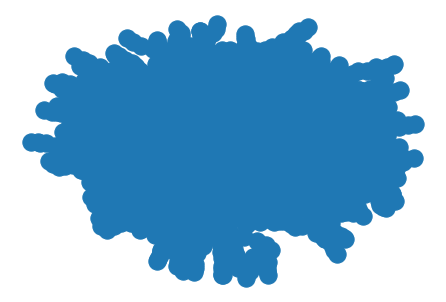

In [13]:
nx.draw(graph)